# Portfolio Rebalancer in Python

Timely and consistent rebalancing is a cornerstone of modern portfolio theory. Rebalancing can magnify returns by selling high and buying low, and reduce long-term risk by ensuring the portfolio adheres to its designated risk tolerance. This project was inspired by a lack of free tools for simply rebalancing an existing portfolio. Sure, we can all use a worksheet to do the math each time, but why not automate it? With inspiration from the work of kdboller we use Pandas, the Tiingo API, and some simple math to calculate how to optimally rebalance a portfolio given a target allocation. This is a simple no-frills portfolio rebalance exercise and does not factor in important considerations such as tax efficiency, transaction costs, or alternate approaches such as stock-out rebalances, or bond-floor settings. Future versions of this project may contemplate these extra factors.  


Steps:  
1. Set triggers to rebalance (time or threshold or both)
2. Define our current Portfolio (accounttype, time, ticker, shares, cost basis, price)  
3. Define our target allocation (ticker, allocation)  
4. Factor in any new money being invested  
5. Calculate initial transactions needed to hit target allocation  
6. Determine which transactions are valid based on rebalance triggers
7. Iteratively determine sells and buys required to get as close as possible to target allocation  


References:

[pythonsp500 by kdboller](https://nbviewer.jupyter.org/github/kdboller/pythonsp500/blob/a7066d998ff046c3cc8b26ece3b0efdf00959d57/Investment%20Portfolio%20Python%20Notebook_03_2018_blog%20example.ipynb)

[Portfolio Rebalancing by bogleheads wiki](https://www.bogleheads.org/wiki/Rebalancing)

In [1]:
#Phases:
#1. (done) Rebalance an existing portfolio
#2. (done) Rebalance new money in
#3. Factor in account types and tax consideratons (Tax Location)
#4. Automatically track portfolio changes/drift using API (will depend on broker capability)
#5. Email alerts

#Feature Ideas:
#Calculate capital gains and losses (and their tax status LT vs. ST)
#Define target allocation at asset-class / domestic-international (or other) levels - then filter it down to securities level
#Enable buying/selling fractional shares for asset types that allow it (ETFs, individual stocks, etc..)
#Factor in trading fees
#Look at what Betterment does for ideas: https://help.betterment.com/hc/en-us/articles/115004257146-How-and-when-is-my-portfolio-rebalanced-?_ga=2.5109811.1454930060.1543610672-1361255251.1543610672
#Convert the top-level allocation to the ticker-level allocation (see: https://docs.google.com/spreadsheets/d/1Ig0sYTdfSqcM2OHJDa7m_vRvQeAQO823s2Nw2rGmL5g/edit#gid=628577776)
#Calculate Tax Location for assets (define optimal tax location depending on the security)
#Calculate Tax Loss Harvesting (maybe a separate app)
#Decide on optimal rebalance strategy (sell assets, invest additional assets, factor in taxable accounts vs. tax deferred)

## Code

In [919]:
#Lets import the necessary packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime
import decimal
from pandas_datareader import data as pdr
from keys import tiingo_key
#define todays datetime
now = datetime.datetime.now()

In [960]:
#Settings
new_money_in = 10000
#Set our rebalance threshold
rebal_threshold = .00 #allowable allocation drift
rebal_timeframe = 90 #in days

In [961]:
#Define target and current allocations
#create our target allocation
columns_t = ['ticker','allocation_target','assetclass']
positions_t = [['VTSAX',0.50,'ST'],
               ['VIGAX',0.0131,'ST'],
               ['VSMAX',0.0066,'ST'],
               ['VSEQX',0.0066,'ST'],
               ['VWIGX',0.0507,'ST'],
               ['VTRIX',0.0507,'ST'],
               ['VTIAX',0.1421,'ST'],
               ['VBTLX',0.035,'BD'],
               ['VTABX',0.015,'BD'],
               ['VGSLX',0.05,'RE'],
               ['VNQI',0.01,'RE'],
               ['VDE',0.03,'ST'],
               ['GLD',0.015,'CS'],
               ['ESGV',0.0066,'ST',],
               ['VSGX',.01,'ST'],
               ['AAPL',0.0039,'ST'],
               ['AMSC',0.0031,'ST'],
               ['ATVI',0.0026,'ST'],
               ['EA',0.0025,'ST'],
               ['NVDA',0.0032,'ST'],
               ['ROBO',0.0062,'ST'],
               ['TCEHY',0.0081,'ST'],
               ['TSLA',.0290,'ST']]

#set our current portfolio
columns_c = ['accounttype','accountid','lastrebaldate','ticker','assetclass','basisdate','costbasis','shares']
positions_c = [['RIRA','3484','2018-11-16','VBTLX','BD','2018-11-16',1,913.483],
             ['RIRA','3484','2018-11-16','VTIAX','ST','2018-11-16',1,514.298],
             ['RIRA','3484','2018-11-16','VTSAX','ST','2018-11-16',10,151.121],
             ['RIRA','6732','2018-11-16','VBTLX','BD','2018-11-16',1,772.407],
             ['RIRA','6732','2018-11-16','VBMFX','BD','2018-11-16',1,0],
             ['RIRA','6732','2018-11-16','VTSAX','ST','2018-11-16',20,151.578],
             ['TAXB','8096','2018-11-16','ATVI','ST','2018-11-16',1,7],
             ['TAXB','8096','2018-11-16','AMSC','ST','2018-11-16',1,41],
             ['TAXB','8096','2018-11-16','AAPL','ST','2018-11-16',1,3.14],
             ['TAXB','8096','2018-11-16','EA','ST','2018-11-16',1,4],
             ['TAXB','8096','2018-11-16','ROBO','ST','2018-11-16',1,24.006],
             ['TAXB','8096','2018-11-16','NVDA','ST','2018-11-16',1,3.01],
             ['TAXB','8096','2018-11-16','TCEHY','ST','2018-11-16',1,25],
             ['TAXB','8096','2018-11-16','TSLA','ST','2018-11-16',1,11],
             ['TAXB','8096','2018-11-16','ESGV','ST','2018-11-16',1,19],
             ['TAXB','8096','2018-11-16','VSGX','ST','2018-11-16',1,20],
             ['TAXB','8096','2018-11-16','VTSAX','ST','2018-11-16',10,549.871],
             ['TAXB','8096','2018-11-16','VMFXX','CS','2018-11-16',1,25516.08]]

In [962]:
#lookup table for account type abbreviations
accounttypes = {'TAXB':'Taxable Brokerage', '401K':'401k', 'RIRA':'Roth-IRA', 'TIRA':'Traditional-IRA'}
assetclasses = {'ST':'Equity Stocks', 'BD':'Bonds Fixed-Income', 'CS':'Cash and Commodities', 'RE':'Real-Estate', 'ALT':'Alternatives'}
assettypes = {'SEC':'Individual Security', 'ETF':'Exchange Traded Fund', 'MF': 'Mutual Fund', 'IF':'Index Fund'}
assetregion = {'D':'Domestic','I':'International'}

#initialize target portfolio
targetalloc = pd.DataFrame(columns = columns_t, data = positions_t)
total=decimal.Decimal(targetalloc.allocation_target.sum())
#check that our target allocation indeed adds to 100%
assert round(total,4) == 1,'Target Allocation not 100% : {}'.format(int(total))

#initialize current portfolio
start_port = pd.DataFrame(columns = columns_c, data = positions_c)
start_port.lastrebaldate = pd.to_datetime(start_port.lastrebaldate)
start_port.basisdate = pd.to_datetime(start_port.basisdate)

#custom apply function
def f(x):
    d = {}
    d['lastrebaldate'] = x['lastrebaldate'].max()
    d['assetclass'] = x['assetclass'].max()
    d['basisdate'] = x['basisdate'].min()
    d['costbasis'] = (x['costbasis'] * x['shares']).sum()/(x['shares'].sum() or 1) #weighted avg
    d['shares'] = x['shares'].sum()
    return pd.Series(d, index=['lastrebaldate', 'assetclass', 'basisdate', 'costbasis', 'shares'])

#aggregate by ticker to account for duplicate securities held in different accounts
agg_port = start_port.groupby(['ticker']).apply(f)

#Define list of distinct tickers we care about
tickers = set(targetalloc.ticker.unique().tolist()+start_port.ticker.unique().tolist())

In [923]:
#Next we pull the latest prices from Tiingo (YahooFinance is buggy, and IEX does not contain mutual fund data)
#Tiingo limits for free API: 500 unique tickers ever, 500 requests/hr, 20,000 requests/day
#https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#tiingo
#Tiingo API key required: set 'tiingo_key' value in python file called 'keys.py' in same directory as this script
now = datetime.datetime.now()
yesterday = now - datetime.timedelta(3) #avoids weekends with no data - need better weekend detection
start = datetime.datetime(yesterday.year, yesterday.month, yesterday.day)
end = datetime.datetime(now.year, now.month, now.day)

bad_tickers = []
for i, t in enumerate(tickers):
    try:
        if i==0:
            ohlc = pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close
        else:
            ohlc = ohlc.append(pdr.get_data_tiingo(t, api_key=tiingo_key).tail(1).close)
    except:
        bad_tickers.append(t)
        
#print(bad_tickers)
ohlc = ohlc.to_frame(name='close')

#drop our date index since its only the latest data
ohlc2=ohlc.reset_index(level=1, drop=True)

#Manual fix for known bad_tickers which Tiingo can't find, adjust to suit your needs
if 'VMFXX' in bad_tickers:
    ohlc2.loc['VMFXX'] = 1.0

In [963]:
#concatenate target allocation and latest prices with our portfolio
start_port_c = pd.merge(agg_port, targetalloc, on ='ticker', how ='outer')
final_port = pd.merge(start_port_c, ohlc2, left_on ='ticker', right_index = True, how = 'left')

#set target to zero for tickers held but not present in our target allocation, set initial basisdate and costbasis for new securities entering the portfolio
final_port.fillna(value = {'allocation_target':0.0,'shares':0.0,'basisdate':pd.to_datetime(now.strftime("%Y-%m-%d")),'costbasis':final_port.close,'assetclass_x':final_port.assetclass_y},inplace = True)
final_port.drop(['assetclass_y'],axis=1,inplace=True)
final_port.rename(columns={'assetclass_x':'assetclass'},inplace=True)

#calculate holding values and current allocation
final_port['value'] = final_port.close * final_port.shares #calculate value as price x shares
final_port.loc[final_port.value.isna() & final_port.shares.isna(),['value']]=0.0 #for securities not currently held but in our target (and close price failed to return), establish zero value
final_port['allocation'] = final_port.value / final_port.value.sum()
final_port['correction'] = final_port.allocation_target - final_port.allocation
final_port['new_money_in'] = new_money_in * final_port.allocation_target #Account for new money in

In [964]:
#create timedelta int column
final_port['timedelta'] = (final_port.lastrebaldate - pd.to_datetime(now.strftime("%Y-%m-%d"))).dt.days
final_port.timedelta.fillna(0,inplace=True)

#define rebalance flags to determine if we must rebalance
final_port['rebal_flag_thresh'] = np.where((abs(final_port.correction)<=rebal_threshold) & (final_port.allocation > 0),0,1)
final_port['rebal_flag_time'] = np.where(final_port.timedelta >= rebal_timeframe,1,0)
final_port['rebal_flag_exit'] = np.where((final_port.allocation > 0) & (final_port.allocation_target==0),1,0) #force rebal securities not present in our target portfolio
final_port['rebal_flag_newmoney'] = np.where(final_port.new_money_in>0,1,0)
final_port['rebal_flag'] = np.where(final_port.rebal_flag_thresh + final_port.rebal_flag_time + final_port.rebal_flag_exit + final_port.rebal_flag_newmoney >= 1,1,0)

#Subset of securities we need to rebalance, and those we need to leave alone
rebal_port = final_port[final_port.rebal_flag==1].copy()
stable_port = final_port[final_port.rebal_flag==0].copy()

In [965]:
#Calculate our current allocation, target, and the change we need to hit target
total_val = rebal_port.value.sum()
rebal_port['allocation'] = rebal_port.value/rebal_port.value.sum()
rebal_port['allocation_target'] = rebal_port.allocation_target/rebal_port.allocation_target.sum()
rebal_port['correction'] = rebal_port.allocation_target - rebal_port.allocation

#Factor in any new money entering the portfolio and determine necessary changes in value and shares
rebal_port['value_chg'] = (total_val * rebal_port.correction) + rebal_port.new_money_in
rebal_port['shares_chg'] = rebal_port.value_chg / rebal_port.close
rebal_port.loc[rebal_port.value_chg.isna() & rebal_port.shares > 0,['shares_chg']]=-rebal_port.shares #sell all shares of securities not in our target portfolio

#Round off shares to whole numbers, except when we are fully exiting a position
rebal_port['shares_chg_round'] = rebal_port.shares_chg
rebal_port = rebal_port.astype({'shares_chg_round': int})
rebal_port['final_shares_chg'] = rebal_port.shares_chg
rebal_port.loc[np.round(rebal_port.shares_chg+rebal_port.shares)!=0,['final_shares_chg']]=rebal_port.shares_chg_round*1.0
rebal_port.drop(['shares_chg_round'],axis=1,inplace=True)

#Calculate initial new shares and values
rebal_port['new_shares'] = np.round(rebal_port.shares + rebal_port.final_shares_chg,3)
rebal_port['new_value'] = rebal_port.new_shares * rebal_port.close #due to share rounding, there will be slight variance vs. portfolio starting value
rebal_port['new_value_chg'] = rebal_port.final_shares_chg * rebal_port.close

In [966]:
#Double check our work so far
#net of buying and selling should be zero
assert(np.round(rebal_port.value_chg.sum(),3)-new_money_in==0) 
#make sure totals match (with rounding error + new money in) from original portfolio and rebalanced portfolio
assert(np.round(rebal_port.new_value.sum() - rebal_port.value.sum(),3)==np.round((rebal_port.new_value.sum() + stable_port.value.sum()) - final_port.value.sum(),3))

In [967]:
#Merge our rebalanced portfolio with our stable portfolio for our execution portfolio
stable_port['value_chg'] = 0
stable_port['shares_chg']=0
stable_port['final_shares_chg'] = 0
stable_port['new_value_chg'] = 0
stable_port['new_shares'] = stable_port.shares
stable_port['new_value'] = stable_port.value
exec_port = pd.concat([rebal_port,stable_port],sort=False)
exec_port.drop(columns=['timedelta','rebal_flag_thresh','rebal_flag_time','rebal_flag_exit','rebal_flag_newmoney','value_chg','shares_chg'],inplace=True)

#Reset allocations to be based on all securities
exec_port['allocation'] = exec_port.value/exec_port.value.sum()
exec_port['allocation_target'] = exec_port.allocation_target/exec_port.allocation_target.sum()
exec_port['correction'] = exec_port.allocation_target - exec_port.allocation
exec_port['final_allocation'] = exec_port.new_value / exec_port.new_value.sum()

In [973]:
#Lets look at all our work to get to our target portfolio
exec_port

,ticker,lastrebaldate,assetclass,basisdate,costbasis,shares,allocation_target,close,value,allocation,correction,new_money_in,rebal_flag,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation
0,AAPL,2018-11-16,ST,2018-11-16,1.000000,3.140,0.0039,146.83,461.04620,0.004052,-0.000152,39.0,1,0.00,3.140,461.04620,0.00,0.003740
1,AMSC,2018-11-16,ST,2018-11-16,1.000000,41.000,0.0031,9.14,374.74000,0.003293,-0.000193,31.0,1,0.00,41.000,374.74000,0.00,0.003040
2,ATVI,2018-11-16,ST,2018-11-16,1.000000,7.000,0.0026,43.99,307.93000,0.002706,-0.000106,26.0,1,0.00,7.000,307.93000,0.00,0.002498
3,EA,2018-11-16,ST,2018-11-16,1.000000,4.000,0.0025,74.72,298.88000,0.002627,-0.000127,25.0,1,0.00,4.000,298.88000,0.00,0.002424
4,ESGV,2018-11-16,ST,2018-11-16,1.000000,19.000,0.0066,40.33,766.27000,0.006734,-0.000134,66.0,1,1.00,20.000,806.60000,40.33,0.006543
5,NVDA,2018-11-16,ST,2018-11-16,1.000000,3.010,0.0032,127.08,382.51080,0.003361,-0.000161,32.0,1,0.00,3.010,382.51080,0.00,0.003103
6,ROBO,2018-11-16,ST,2018-11-16,1.000000,24.006,0.0062,30.86,740.82516,0.006510,-0.000310,62.0,1,0.00,24.006,740.82516,0.00,0.006009
7,TCEHY,2018-11-16,ST,2018-11-16,1.000000,25.000,0.0081,38.90,972.50000,0.008546,-0.000446,81.0,1,0.00,25.000,972.50000,0.00,0.007888
8,TSLA,2018-11-16,ST,2018-11-16,1.000000,11.000,0.0290,295.39,3249.29000,0.028555,0.000445,290.0,1,1.00,12.000,3544.68000,295.39,0.028752
9,VBMFX,2018-11-16,BD,2018-11-16,0.000000,0.000,0.0000,10.43,0.00000,0.000000,0.000000,0.0,1,0.00,0.000,0.00000,0.00,0.000000


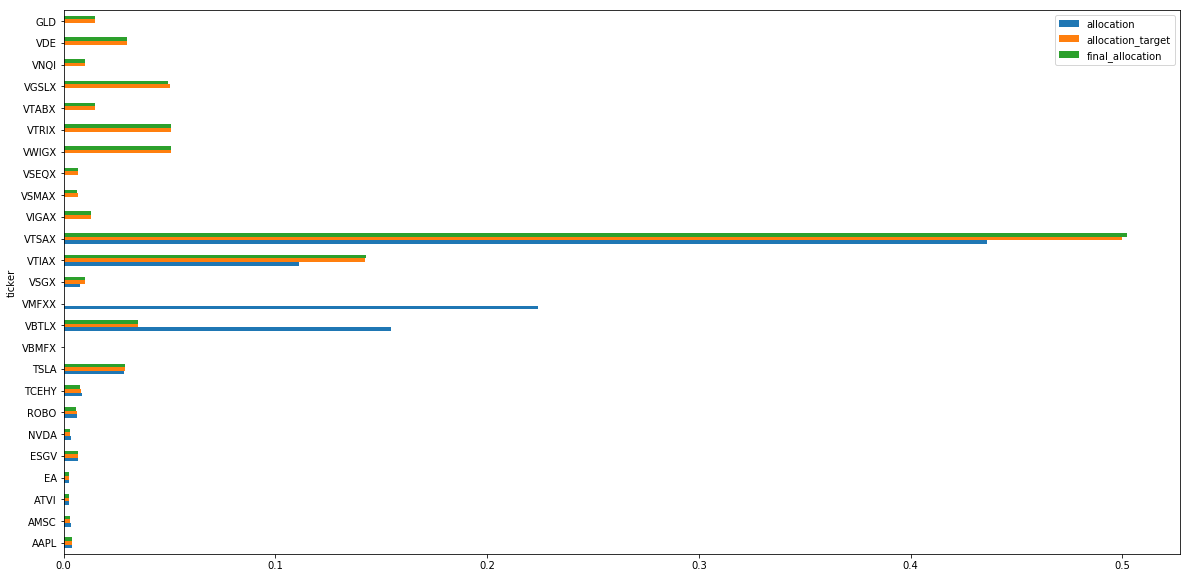

In [974]:
#Lets add a bar chart here to show the new allocation vs. the target allocation and vs. the original portfolio
graph_port = exec_port[['ticker','allocation','allocation_target','final_allocation']].copy()
graph_port.plot.barh(x='ticker',figsize=(20,10))

In [978]:
#Next we turn our ticker-level strategy into account level actions
#Join in our rebalanced portfolio and determine how to split value across accounts for a given ticker
port = pd.merge(start_port[['accounttype','accountid','ticker','shares']], 
                   exec_port[['ticker','assetclass','close','value','final_shares_chg','new_shares','new_value','new_value_chg','final_allocation']], 
                   how = 'right', 
                   left_on = 'ticker', 
                   right_on = 'ticker')
port['value_orig'] = port.close * port.shares
#Calculate the value-weight of each ticker by account
port['tick_alloc'] = port.value_orig / port.value #What pct of each ticker is in a given account?
port['tick_alloc'].fillna(1.0,inplace=True)
#check our sub-allocations
assert(port.groupby('ticker').tick_alloc.sum().sum() == len(port.groupby('ticker').tick_alloc.sum()))

#port.fillna({'assetclass_x':final_port.assetclass_y})

#Recalculate the values proportionately
port['final_shares_chg'] = port.final_shares_chg * port.tick_alloc
port['new_shares'] = port.new_shares * port.tick_alloc
port['new_value'] = port.new_value * port.tick_alloc
port['new_value_chg'] = port.new_value_chg * port.tick_alloc
port['final_allocation'] = port.final_allocation * port.tick_alloc
port['value'] = port.value * port.tick_alloc
port.drop(['value_orig','tick_alloc'],axis=1,inplace=True)

#double check our final_allocation is 100%
assert(np.round(port.final_allocation.sum(),4)==1.0)

#Lets look at our final portfolio at the account level
port

,accounttype,accountid,ticker,shares,assetclass,close,value,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation
0,RIRA,3484,VBTLX,913.483,BD,10.43,9527.62769,-688.137073,225.345927,2350.358019,-7177.269671,0.019064
1,RIRA,6732,VBTLX,772.407,BD,10.43,8056.20501,-581.862927,190.544073,1987.374681,-6068.830329,0.016120
2,RIRA,3484,VTIAX,514.298,ST,24.62,12662.01676,200.000000,714.298000,17586.016760,4924.000000,0.142644
3,RIRA,3484,VTSAX,151.121,ST,58.19,8793.73099,37.400484,188.521484,10970.065178,2176.334188,0.088981
4,RIRA,6732,VTSAX,151.578,ST,58.19,8820.32382,37.513586,189.091586,11003.239388,2182.915568,0.089250
5,TAXB,8096,VTSAX,549.871,ST,58.19,31996.99349,136.085930,685.956930,39915.833733,7918.840243,0.323766
6,RIRA,6732,VBMFX,0.000,BD,10.43,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
7,TAXB,8096,ATVI,7.000,ST,43.99,307.93000,0.000000,7.000000,307.930000,0.000000,0.002498
8,TAXB,8096,AMSC,41.000,ST,9.14,374.74000,0.000000,41.000000,374.740000,0.000000,0.003040
9,TAXB,8096,AAPL,3.140,ST,146.83,461.04620,0.000000,3.140000,461.046200,0.000000,0.003740


In [1023]:
#Finally, all new tickers need an account to land in
dport = None
acctsdf = None
if len(port[port.accounttype.isnull()])>0: #if we have none, skip this step
    print('Distributing new securities to existing accounts . . .')
    dport = port.copy()

    #account-level fund surplus or deficit - must match these with our orphaned securities
    accts = []
    for i in list(zip(port.groupby(['accountid','accounttype']).new_value_chg.sum().index.values,port.groupby(['accountid','accounttype']).new_value_chg.sum().values)):
        accts.append([i[0][0],i[0][1],i[1]])
    acctsdf = pd.DataFrame(data=accts,columns=['accountid','accounttype','new_value_chg_sum'])
    #establish sort order so we can allocate tax-efficient account space first
    actype_sortorder = pd.DataFrame(data=[['RIRA',1],['TIRA',2],['TAXB',3]],columns=['accounttype','order'])
    acctsdf = pd.merge(acctsdf,actype_sortorder,how='left',left_on='accounttype',right_on='accounttype')
    #We make a consequential assumption here that any new_money_in will be allocated 100% in one of the Taxable accounts (first in list).
    #if you have a Roth-IRA which has not met its contribution limits for the year, it may be preferrential to distribute the funds there first.
    min_idx = acctsdf[acctsdf.accounttype == 'TAXB'].index.min()
    acctsdf.loc[min_idx,'new_value_chg_sum'] = acctsdf.loc[min_idx,'new_value_chg_sum'] - new_money_in
    #only return accounts that have space
    acctsdf = acctsdf[acctsdf.new_value_chg_sum<0].copy()

    #establish sort order so we can allocate tax-inefficient assets first
    aclass_sortorder = pd.DataFrame(data=[['ST',3],['BD',1],['CS',4],['RE',2],['ALT',5]],columns=['assetclass','order'])
    dport = pd.merge(dport,aclass_sortorder,how='left',left_on='assetclass',right_on='assetclass')

    #loop through orphaned tickers and place them in accounts until all assets are allocated or we are forced to split a security across accounts
    #  in this loop we do not allow tax-inefficient assets to wind up in Taxable accounts
    for index, row in dport[dport.accounttype.isnull()].sort_values(['order','new_value_chg'],ascending=[True,False]).iterrows():
        #loop through accounts and place the assets
        for i, r in acctsdf.iterrows():
            aid = r.accountid
            atype = r.accounttype
            bal = r.new_value_chg_sum
            #print('Evaluating {}-{} with {} starting bal'.format(aid,atype,bal))
            if row.assetclass in ('BD','RE') and atype == 'TAXB':
                continue #skip this case, since we don't want to place Bonds and Real-Estate assets in Taxable accounts
            elif row.assetclass not in ('BD','RE') and atype != 'TAXB':
                continue #skip this case, since we don't want to place tax-efficient assets into tax sheltered accounts 

            if row.new_value_chg + bal <=0: #it fits
                bal+=row.new_value_chg
                print(' FITS {} in {}-{} with {} remaining'.format(row.ticker,aid,atype,bal))
                #update our portfolio
                dport.loc[index,'accountid'] = aid
                dport.loc[index,'accounttype'] = atype
                #update account bal for next loop
                acctsdf.loc[i,'new_value_chg_sum'] = bal
                break
            else:
                print(' {} {} does not fit in {}-{}'.format(row.ticker,row.new_value_chg,aid,atype))


    #Here we are forced to split a security across multiple accounts because no one account can fit it
    #  in this loop we allow tax-inefficient assets to wind up in Taxable accounts, but only as a last resort
    if len(dport[dport.accounttype.isnull()])>0:
        print('\nSplitting remaining securities across accounts . . .')
        #loop through accounts and place portions of asset in each, create a new row in the df for each placement.
        for index, row in dport[dport.accounttype.isnull()].sort_values(['order','new_value_chg'],ascending=[True,False]).iterrows():
            final_shares_chg = row.final_shares_chg
            new_value_chg = row.new_value_chg
            #if its a tax-inefficent asset, order the accounts by 'order'
            if row.assetclass in ('BD','RE'):
                acctsdf = acctsdf.sort_values('order',ascending=True)
            else:
                acctsdf = acctsdf.sort_values('order',ascending=False)
                
            for i, r in acctsdf.iterrows():
                bal = r.new_value_chg_sum
                pct_move = -bal/row.new_value_chg
                new_value_chg+=bal
                print(' {} move {} or {}% into account {}-{}. {} bal remaining {}'.format(row.ticker,-bal,pct_move,r.accountid,r.accounttype,row.ticker,new_value_chg))
                
                #update our account to reflect this change
                if new_value_chg > 0:
                    acctsdf.loc[i,'new_value_chg_sum'] = 0.0
                else:
                    acctsdf.loc[i,'new_value_chg_sum'] = new_value_chg
                    
                #create new row in our portfolio for this asset in this account
                dport.loc[max(dport.index)+1] = [r.accounttype,
                                        r.accountid,
                                        row.ticker,
                                        row.shares,
                                        row.assetclass,
                                        row.close,
                                        row.value,
                                        np.floor(pct_move*row.final_shares_chg), #we round down to get back to whole shares
                                        np.floor(pct_move*row.new_shares),
                                        np.floor(pct_move*row.new_shares)*row.close,
                                        (np.floor(pct_move*row.new_shares)*row.close)-row.value,
                                        np.floor(pct_move*row.new_value)/dport.new_value.sum(),
                                        row.order]
                
                #finally delete the original row from the df
                dport.drop(dport[dport.accounttype.isnull()].index,inplace=True)

Distributing new securities to existing accounts . . .
 VTABX 1840.2499999999998 does not fit in 3484-RIRA
 FITS VTABX in 6732-RIRA with -2045.6647603632198 remaining
 VGSLX 6093.0 does not fit in 3484-RIRA
 VGSLX 6093.0 does not fit in 6732-RIRA
 VNQI 1229.76 does not fit in 3484-RIRA
 FITS VNQI in 6732-RIRA with -815.9047603632198 remaining
 FITS VWIGX in 8096-TAXB with -20650.859756512662 remaining
 FITS VTRIX in 8096-TAXB with -14389.709756512662 remaining
 FITS VDE in 8096-TAXB with -10698.839756512662 remaining
 FITS VIGAX in 8096-TAXB with -9090.589756512662 remaining
 FITS VSEQX in 8096-TAXB with -8278.429756512662 remaining
 FITS VSMAX in 8096-TAXB with -7507.139756512662 remaining
 FITS GLD in 8096-TAXB with -5706.839756512662 remaining

Splitting remaining securities across accounts . . .
 VGSLX move 76.9354831241194 or 0.01262686412672237% into account 3484-RIRA. VGSLX bal remaining 6016.06451687588
 VGSLX move 815.9047603632198 or 0.13390854429069748% into account 6732-RIR

In [1024]:
#Lets see whats left in our accounts, it should be very close to zero
acctsdf

,accountid,accounttype,new_value_chg_sum,order
0,3484,RIRA,0.00,1
1,6732,RIRA,0.00,1
2,8096,TAXB,-506.68,3


In [1025]:
#Cleanup
dport.drop(columns=['order'],inplace=True)
dport = dport[['accounttype','accountid','ticker','shares','assetclass','close','value','new_shares','final_shares_chg','new_value','new_value_chg','final_allocation']]

In [1030]:
#Review our final portfolio with recommended buys/sells in 'final_shares_chg' column
dport

,accounttype,accountid,ticker,shares,assetclass,close,value,new_shares,final_shares_chg,new_value,new_value_chg,final_allocation
0,RIRA,3484,VBTLX,913.483,BD,10.43,9527.62769,225.345927,-688.137073,2350.358019,-7177.269671,0.019064
1,RIRA,6732,VBTLX,772.407,BD,10.43,8056.20501,190.544073,-581.862927,1987.374681,-6068.830329,0.016120
2,RIRA,3484,VTIAX,514.298,ST,24.62,12662.01676,714.298000,200.000000,17586.016760,4924.000000,0.142644
3,RIRA,3484,VTSAX,151.121,ST,58.19,8793.73099,188.521484,37.400484,10970.065178,2176.334188,0.088981
4,RIRA,6732,VTSAX,151.578,ST,58.19,8820.32382,189.091586,37.513586,11003.239388,2182.915568,0.089250
5,TAXB,8096,VTSAX,549.871,ST,58.19,31996.99349,685.956930,136.085930,39915.833733,7918.840243,0.323766
6,RIRA,6732,VBMFX,0.000,BD,10.43,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
7,TAXB,8096,ATVI,7.000,ST,43.99,307.93000,7.000000,0.000000,307.930000,0.000000,0.002498
8,TAXB,8096,AMSC,41.000,ST,9.14,374.74000,41.000000,0.000000,374.740000,0.000000,0.003040
9,TAXB,8096,AAPL,3.140,ST,146.83,461.04620,3.140000,0.000000,461.046200,0.000000,0.003740


In [694]:
#Run Tax Location Logic
#Based on widely-accepted Tax Location strategies we will re-allocate assets to tax optimize
#https://www.bogleheads.org/wiki/Tax-efficient_fund_placement

#Make this process optional w/ feature_toggle

#We can't move funds across accounts (esp. tax advantaged), so distribute funds within account to best asset classes within target allocation
#Allocate funds in each assetclass to proper accounttype (limited by total funds already in that account)
#'BD' and 'RE' go into tax-deferred accounts
#'CS' and 'ST' and 'ALT' go into any leftover accounts
#Then extrapolate down to the ticket level
#print(tax_loc.groupby('accountid').value_orig.sum())
#print(accounttypes)
#print(assetclasses)

#Tax efficient investments can be placed anywhere, but we focus on new investments and moving existing tax inefficient investments out of ineffcient account placements
move_tickers = []
for index, row in tax_loc[['accountid','accounttype','ticker','assetclass','new_shares','new_value']].sort_values(by='accountid').iterrows():
    if row.accounttype == 'TAXB' and row.assetclass in ('BD','RE'):
        move_tickers.append([row.accountid, row.ticker, row.assetclass, row.new_shares, row.new_value])
    elif row.accounttype not in accounttypes.keys() and row.assetclass in ('BD','RE'):
        new_place_tickers.append([row.accountid, row.ticker, row.assetclass, row.new_shares, row.new_value])
        
print(move_tickers)

#Now find assets to swap with, ex. sell stocks in A and buy bonds, buy bonds in B and sell stocks. 


#all new tickers need an account to land in
tax_loc[tax_loc.accounttype.isnull()]
    

[['8096', 'VBTLX', 'BD', 224.2622465700609, 2334.569986794334]]


,accounttype,accountid,ticker,shares,assetclass,close,value,final_shares_chg,new_shares,new_value,new_value_chg,final_allocation,value_orig,tick_alloc
18,NaN,NaN,VIGAX,NaN,ST,67.98,0.0,23.0,23.0,1563.54,1563.54,0.013373,NaN,1.0
19,NaN,NaN,VSMAX,NaN,ST,62.50,0.0,12.0,12.0,750.00,750.00,0.006415,NaN,1.0
20,NaN,NaN,VSEQX,NaN,ST,26.57,0.0,30.0,30.0,797.10,797.10,0.006817,NaN,1.0
21,NaN,NaN,VWIGX,NaN,ST,24.62,0.0,253.0,253.0,6228.86,6228.86,0.053274,NaN,1.0
22,NaN,NaN,VTRIX,NaN,ST,31.91,0.0,195.0,195.0,6222.45,6222.45,0.053219,NaN,1.0
23,NaN,NaN,VTABX,NaN,BD,22.09,0.0,83.0,83.0,1833.47,1833.47,0.015681,NaN,1.0
24,NaN,NaN,VGSLX,NaN,RE,107.01,0.0,57.0,57.0,6099.57,6099.57,0.052168,NaN,1.0
25,NaN,NaN,VNQI,NaN,RE,53.06,0.0,23.0,23.0,1220.38,1220.38,0.010438,NaN,1.0
26,NaN,NaN,VDE,NaN,ST,75.32,0.0,48.0,48.0,3615.36,3615.36,0.030921,NaN,1.0
27,NaN,NaN,GLD,NaN,CS,118.72,0.0,15.0,15.0,1780.80,1780.80,0.015231,NaN,1.0


## Conclusion
Through this portfolio rebalancing demonstration using Pandas you can see we have achieved a rebalanced portfolio very closely approximating our desired target allocation. We can see how GLD was added as a new security, and AAPL was removed from the portfolio. The remaining securities were iteratively bought or sold as required by our target allocation. We accounted for whole-share rounding because most of our assets in this sample are index funds. This simple rebalancer can be adapted to your needs and I urge you grab the code and see if you can improve upon it. I welcome your thoughts or feedback in the comments.